<h1 align="center">Estatística Computacional</h1>
<h3 align="center">Gabriel Lima Novais</h3>
<p> O trabalho final será a implementação do algoritmo conhecido como <b>Double Metropolis-Hastings</b> (DMH) para redes, mais especificamente, para <b>Exponential Random Graphs Models</b> (ERGM). A replicação será do artigo "Bayesian Analysis for Exponential Random Graph Models Using the Double Metropolis-Hastings Sampler", cujos autores são Ick Hoon Jin e Faming Liang. O link do artigo encontra-se destacado abaixo.</p>


<p><a href="https://amstat.tandfonline.com/doi/full/10.1080/01621459.2018.1448824">Artigo de Apoio</a></p>
<p><a href="https://www.researchgate.net/publication/265920670_Bayesian_Analysis_for_Exponential_Random_Graph_Models_Using_the_Double_Metropolis-Hastings_Sampler">Artigo de Replicação</a></p>

<p>Link do repositório no github:</p>
<ul>
    <li><a href="https://github.com/NovaisGabriel/-Computational-Statistics">Repositório do Aluno</a></li>
   </ul>


<p>Links interessantes sobre o assunto:</p>
<ul>
    <li><a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3956133/">Artigo 1</a></li>
    <li><a href="https://www.researchgate.net/publication/236264661_A_Monte_Carlo_Metropolis-Hastings_Algorithm_for_Sampling_from_Distributions_with_Intractable_Normalizing_Constants/link/02e7e536166f37096b000000/download">Artigo 2</a></li>
    <li><a href="https://arxiv.org/pdf/1904.08063.pdf">Artigo 3</a></li>
</ul>

### Importando Pacotes:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import networkx as nx

from itertools import chain 
from IPython.display import clear_output
from progressbar import ProgressBar
from tqdm import tqdm

### Função $D_i(x)$

In [2]:
def D(net_inc):
    number = []
    d=[]
    for i in range(len(net_inc)):
        number.append(np.sum(net_inc[i]))
    my_dict = {i:number.count(i) for i in number}
    for x in range(len(net_inc)):
        try:
            d.append(my_dict[x])
        except:
            d.append(0)
    return d

### Função $EP_i(x)$

In [3]:
def EP(net_inc):
    pares=[]
    M=[]
    ep=[]
    resultado = 0
    for la in range(len(net_inc)):
        for lnex in range(la+1,len(net_inc)):
            if net_inc[la][lnex]>0:
                pares.append(net_inc[la]+net_inc[lnex])
    for h in range(len(pares)):
        M.append(list(pares[h]).count(2))
    my_dict = {i:M.count(i) for i in M}
    for x in range(len(M)):
        try:
            ep.append(my_dict[x])
        except:
            ep.append(0)
    
    return ep

### Funções de Estatísticas Suficientes:

<img src="S1.png">

In [4]:
#Number of Edges (NE) Statistic -> e(x):
def NE(net_inc):
    result = 0.5*(np.dot(list(range(len(net_inc))),D(net_inc)))
    return result

<img src="S2.png">

In [5]:
#Geometrically Weighted Degree (GWD) Statistic -> u(x|tau)
def GWD(net_inc,tau):
    result = 0
    for i in range(1,len(net_inc)-1):
        termo = 1-(1-np.exp(-tau))**i
        result = result + termo*D(net_inc)[i]
    result = np.exp(tau)*result
    return result

<img src="S3.png">

In [6]:
#Geometrically Weighted Edgewise Shared Partnership (GWESP) Statistic -> v(x|tau): 
def GWESP(net_inc,tau):
    result = 0
    for i in range(0,len(net_inc)-2):
        termo = 1-(1-np.exp(-tau))**i
        ep = EP(net_inc)
        if i>=len(ep):
            result = result+0
        else:
            result = result + termo*ep[i]
    result = np.exp(tau)*result
    return result

### Funções de Modelo

<img src="Models.png">

In [7]:
#Model 1:
def PHI_model1(x,theta,tau):
    return np.exp(np.dot(theta,[NE(x),GWD(x,tau)]))

In [8]:
#Model 2:
def PHI_model2(x,theta,tau):
    return np.exp(np.dot(theta,[NE(x),GWESP(x,tau)]))

In [9]:
#Model 3:
def PHI_model3(x,theta,tau):
    return np.exp(np.dot(theta,[NE(x),GWD(x,tau),GWESP(x,tau)]))

### Double Metropolis Hastings

<img src="exp.png">

<img src="change.png">

In [15]:
def DMH(x,dim,n_iter,ss,tau,var_init):
    
    #Initialize:
    thetas = []
    tzero = np.random.multivariate_normal(np.zeros(dim),var_init*np.identity(dim),1) 
    thetas.append(tzero)
    
    #Primeiro Theta a ser testado:
    tnow = thetas[0]
    
    #Double Metropolis-Hastings
    for t in tqdm(range(0,n_iter)):
        
        #Gerando Thetas novos:
        tline = np.random.multivariate_normal(tnow[0],(ss**2)*np.identity(dim),1) 

        #Aplicando m MH:
        y = x.copy()
        for i in range(len(x)):
            for j in range(len(x)):
                if i<j :
                    z = y.copy()
                    w = y.copy()
                    z[i,j]=1
                    w[i,j]=0
                    z[j,i]=1
                    w[j,i]=0
                    num = PHI_model2(z,tline,tau)
                    den = PHI_model2(w,tline,tau)+PHI_model2(z,tline,tau)
                    prob = num/den

                    if np.random.uniform(0,1)<prob:
                        y[i,j]=1
                        y[j,i]=1
                    else:
                        y[i,j]=0
                        y[j,i]=0


                
        #Segundo MH:
        low = np.log(PHI_model2(x,tnow,tau))+np.log(PHI_model2(y,tline,tau))
        high = np.log(PHI_model2(y,tnow,tau))+np.log(PHI_model2(x,tline,tau))
        r = np.exp(high-low)
        alpha = np.min([1,r])

        alpha = 0.5
        #Acceptance:
        if np.random.uniform(0,1)<alpha:
            thetas.append(tline)
            tnow = tline
    
    #Results:
    return thetas        

### Examplo para o caso 10:

In [19]:
# Valores que devem dar dessa ERGM: Theta1 = -1.66 e Theta2 = 0.15
teste = np.array([[0., 1., 1., 1., 1., 0., 0., 1., 0., 0.],
                  [1., 0., 0., 0., 1., 1., 0., 0., 1., 1.],
                  [1., 0., 0., 1., 1., 0., 0., 1., 1., 1.],
                  [1., 0., 1., 0., 0., 0., 0., 0., 1., 1.],
                  [1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
                  [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
                  [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
                  [1., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
                  [0., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
                  [0., 1., 1., 1., 1., 1., 0., 1., 0., 0.]])

In [17]:
x = teste
dim=2
n_iter=1000
ss=0.2
tau=0.25
var_init = 200

100%|██████████| 1000/1000 [03:19<00:00,  5.52it/s]


Certo -> [-1.66000000  0.15000000]
E deu -> [ 15.63872138 -15.54168446]


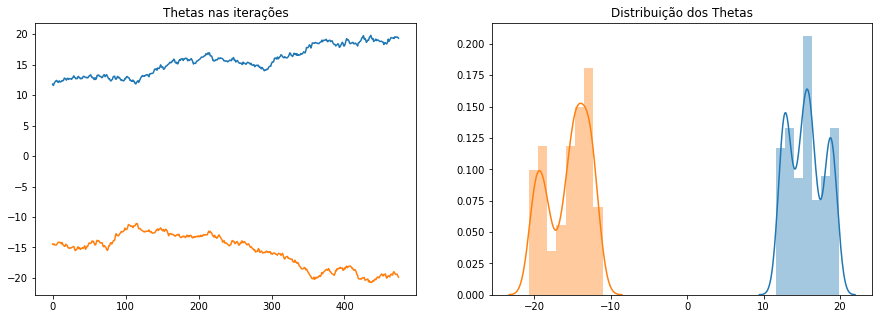

In [18]:
thetas = DMH(x,dim,n_iter,ss,tau,var_init)
BayesEstimator = np.mean(thetas[:],axis=0)[0]
print("Certo -> [-1.66000000  0.15000000]")
print("E deu ->",BayesEstimator)
theta1 = [x[0][0] for x in thetas]
theta2 = [x[0][1] for x in thetas]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(range(len(theta1)),theta1)
ax1.plot(range(len(theta1)),theta2)
sns.distplot(theta1)
sns.distplot(theta2)
ax1.set_title('Thetas nas iterações')
ax2.set_title('Distribuição dos Thetas')

plt.show()

### Exemplo para o caso 50:
Infelizmente não está rodando... :(

In [ ]:
# #-3.194226  0.389997 
# teste2 = pd.read_csv("graph.csv")
# teste2 = teste2.iloc[:,1:]
# teste2 = np.array(teste2)
# teste2

In [ ]:
# x = teste2
# dim=2
# n_iter=10
# ss=0.2
# tau=0.25
# var_init = 100

In [ ]:
# thetas = DMH(x,dim,n_iter,ss,tau,var_init)

In [ ]:
# BayesEstimator = np.mean(thetas[:],axis=0)[0]
# print("Certo -> [-3.194226  0.389997 ]")
# print("E deu ->",BayesEstimator)

In [ ]:
# t = np.zeros((len(thetas),len(thetas)))
# for i,m in enumerate(thetas):
#     t[i][0] = m[0][0]
#     t[i][1] = m[0][1]
# plt.plot(t)
# plt.show()

In [ ]:
# theta1 = [x[0][0] for x in thetas]
# theta2 = [x[0][1] for x in thetas]
# sns.distplot(theta1)
# sns.distplot(theta2)